In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib as plt
import seaborn as sns

In [31]:
df_test = pd.read_csv("titanic/test.csv")
df_train = pd.read_csv("titanic/train.csv")

In [32]:
#Too much missing values for cabin
df_test = df_test.drop(columns="Cabin")
df_train = df_train.drop(columns="Cabin")
#Then drop de entries with missing values
df_train = df_train.dropna()
#df_test = df_test.dropna()


In [33]:
#Categorize sex
df_train["Sex"] = df_train["Sex"].astype("category")
df_train["Sex"] = df_train["Sex"].cat.codes
df_test["Sex"] = df_test["Sex"].astype("category")
df_test["Sex"] = df_test["Sex"].cat.codes

In [34]:
#Compress age
df_train["Age"] = df_train["Age"].astype("int64")
#df_test["Age"] = df_test["Age"].astype("int64")

In [35]:
#Categorize port of embarkment
df_train["Embarked"] = df_train["Embarked"].astype("category")
df_train["Embarked"] = df_train["Embarked"].cat.codes
df_test["Embarked"] = df_test["Embarked"].astype("category")
df_test["Embarked"] = df_test["Embarked"].cat.codes

In [36]:
# New variable of number of relatives
df_train["n_family"] = 1 + df_train["SibSp"] + df_train["Parch"]
df_test["n_family"] = 1 + df_test["SibSp"] + df_test["Parch"]

In [37]:
#Split ticket and categorize 
df_train["Ticket_cat"] = df_train["Ticket"].apply(lambda x: x.split(" ")[0])
df_train['Ticket_cat'] = df_train['Ticket_cat'].apply(lambda x: 0 if x.isnumeric() else x)
df_test["Ticket_cat"] = df_test["Ticket"].apply(lambda x: x.split(" ")[0])
df_test['Ticket_cat'] = df_test['Ticket_cat'].apply(lambda x: 0 if x.isnumeric() else x)


In [38]:
df_train["Ticket_cat"] = df_train["Ticket_cat"].astype("category")
df_train["Ticket_cat"] = df_train["Ticket_cat"].cat.codes
df_test["Ticket_cat"] = df_test["Ticket_cat"].astype("category")
df_test["Ticket_cat"] = df_test["Ticket_cat"].cat.codes

In [39]:
#Drop data not encoded
df_test = df_test.drop(columns=["SibSp", "Parch", "Ticket", "Name"])
df_train = df_train.drop(columns=["SibSp", "Parch", "Ticket", "Name"])

['PassengerId' 'Survived' 'Pclass' 'Sex' 'Age' 'Fare' 'Embarked'
 'n_family' 'Ticket_cat']


<AxesSubplot:>

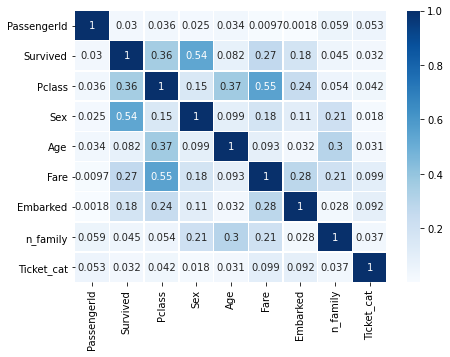

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,5))
features =  [df_train.columns.values]
print(features[0])
sns.heatmap(np.abs(df_train[features[0]].corr()), annot=True, linewidths=.5, cmap='Blues', ax=ax)

In [11]:
#Separate labels and dataset
train_labels = df_train["Survived"]
#test_labels = df_test["Survived"]


In [12]:
df_train = df_train.drop(columns=["Survived"])

In [13]:
df_train

,PassengerId,Pclass,Sex,Age,Fare,Embarked,n_family,Ticket_cat
0,1,3,1,22,7.2500,2,2,5
1,2,1,0,38,71.2833,0,2,16
2,3,3,0,26,7.9250,2,1,34
3,4,1,0,35,53.1000,2,2,0
4,5,3,1,35,8.0500,2,1,0
...,...,...,...,...,...,...,...,...
885,886,3,0,39,29.1250,1,6,0
886,887,2,1,27,13.0000,2,1,0
887,888,1,0,19,30.0000,2,1,0
889,890,1,1,26,30.0000,0,1,0


['PassengerId' 'Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'n_family'
 'Ticket_cat']


<AxesSubplot:>

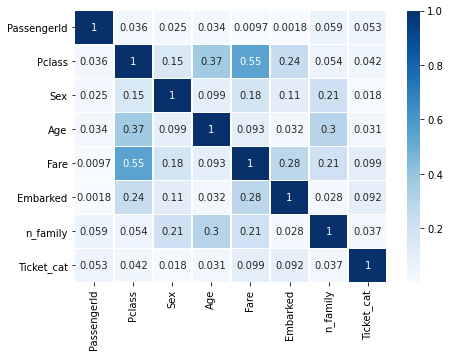

In [14]:
#feature_columns = ["Pclass", "Sex", "Age", "Fare", "Embarked", "n_family", "Ticket_cat"]

CATEGORICAL_COLUMNS = ['Sex', 'Pclass', 'Embarked', 'n_family', 'Ticket_cat']
NUMERIC_COLUMNS = ['Age', 'Fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = df_train[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [15]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

def input_fn_predict(data_df, num_epochs=1, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), None))
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function


In [16]:
train_input_fn = make_input_fn(df_train, train_labels)
#eval_input_fn = make_input_fn(df_train, train_labels, num_epochs=1, shuffle=False)


In [17]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Simon\\AppData\\Local\\Temp\\tmp4r762f69', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initializ

In [64]:
predicts = linear_est.predict(input_fn=input_fn_predict(df_test))
pred_dicts = list(predicts)
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Simon\AppData\Local\Temp\tmp4r762f69\model.ckpt-230
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

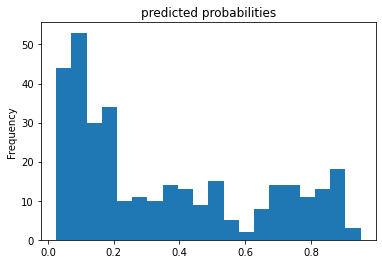

In [65]:
probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [80]:
y_pred = (probs > 0.5) * 1
submission = pd.DataFrame({
        'PassengerId': df_test["PassengerId"],
        'Survived': y_pred
    })
print(submission)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [ ]:
submission.to_csv("gender_submission.csv",index=False)
